In [ ]:
# Adapted from Assignment 3
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [ ]:
from torchvision.datasets import ImageFolder

# Create transformations to apply to data
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset
train_dataset = ImageFolder(root="./data/images/train", transform=transform)
test_dataset = ImageFolder(root="./data/images/validation", transform=transform)

# Create Dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [4]:
class EnjoymentClassifier(nn.Module):
    def __init__(self, num_classes):
        super(EnjoymentClassifier, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.4)
        )
        
        self.feature_dim = 128 * 16 * 16 
        self.fc = nn.Linear(self.feature_dim, num_classes)

        
    def forward(self, x):
        x = self.conv1(x)  # [B, 32, 64, 64]
        x = self.conv2(x)  # [B, 64, 32, 32]
        x = self.conv3(x)  # [B, 128, 16, 16]
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x
        

In [ ]:
# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model
model = EnjoymentClassifier(num_classes=3).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # change the learning rate as you want

## TRAIN:

In [9]:
num_epochs =  51# set the number of epochs for training
'''
for images, labels in train_loader:
    print("Sample input shape:", images.shape)  # Should be [64, 1, 128, 128]
    outputs = model(images)
    print("Sample output shape:", outputs.shape)  # Should be [64, num_classes]
    break
'''

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Loop over each batch
    for i, (sequences, labels) in enumerate(train_loader):
        sequences, labels = sequences.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(sequences)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Optimize the model
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        running_loss += loss.item()

    # Print statistics for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    # it is recommand to save the model regulary during training if you don't have a lof of computational resource

    root_path = "./saved_models"
    model_dir = os.path.join(root_path, "model_configs")
    os.makedirs(model_dir, exist_ok=True)
    if epoch%5 ==0: # change the saving frequency as you want
        model_path = os.path.join(root_path, 'model_configs', f'image_model_{epoch}.pth')
        torch.save(model.state_dict(), model_path)


Epoch [1/51], Loss: 1.1730, Accuracy: 45.94%
Epoch [2/51], Loss: 1.0549, Accuracy: 51.31%
Epoch [3/51], Loss: 1.0035, Accuracy: 53.78%
Epoch [4/51], Loss: 0.9880, Accuracy: 54.87%
Epoch [5/51], Loss: 0.9762, Accuracy: 55.32%
Epoch [6/51], Loss: 0.9438, Accuracy: 57.20%
Epoch [7/51], Loss: 0.9196, Accuracy: 58.11%
Epoch [8/51], Loss: 0.8958, Accuracy: 59.59%
Epoch [9/51], Loss: 0.8821, Accuracy: 60.60%
Epoch [10/51], Loss: 0.8770, Accuracy: 60.93%
Epoch [11/51], Loss: 0.8648, Accuracy: 61.74%
Epoch [12/51], Loss: 0.8532, Accuracy: 62.37%
Epoch [13/51], Loss: 0.8420, Accuracy: 62.38%
Epoch [14/51], Loss: 0.8318, Accuracy: 63.44%
Epoch [15/51], Loss: 0.8271, Accuracy: 63.44%
Epoch [16/51], Loss: 0.8118, Accuracy: 64.16%
Epoch [17/51], Loss: 0.8055, Accuracy: 64.13%
Epoch [18/51], Loss: 0.8003, Accuracy: 64.77%
Epoch [19/51], Loss: 0.8004, Accuracy: 64.42%
Epoch [20/51], Loss: 0.7903, Accuracy: 65.37%
Epoch [21/51], Loss: 0.7901, Accuracy: 64.94%
Epoch [22/51], Loss: 0.7776, Accuracy: 65.9

In [5]:
model = EnjoymentClassifier(num_classes=3)
model.load_state_dict(torch.load("./saved_models/model_configs/image_model_50.pth"))  # Load the desired saved model weights, change the path if needed
model.eval()  # Set the model to evaluation mode

EnjoymentClassifier(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.4, inplace

72.10697325668583
              precision    recall  f1-score   support

       angry       0.65      0.52      0.58       960
       happy       0.81      0.83      0.82      1825
     neutral       0.65      0.72      0.68      1216

    accuracy                           0.72      4001
   macro avg       0.70      0.69      0.69      4001
weighted avg       0.72      0.72      0.72      4001



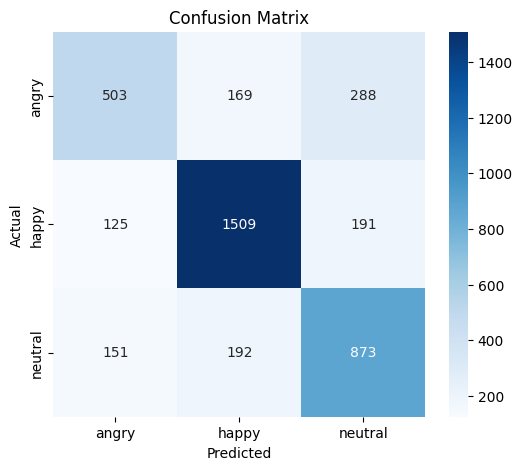

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html for confusion_matrix
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html for classification report 
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#gesture_labels = {0: "Swipe Left", 1: "Swipe Right", 2: "Stop", 3: "Thumbs Up", 4: "Thumbs Down"}\
gesture_labels = {
    0: "angry",
    1: "happy",
    2: "neutral"
}
predictions = []
labels_test = []

#copy pasted and edited from the training and changed to test
with torch.no_grad():  # No gradients needed for inference
    correct = 0
    total=0
    for i, (sequences, labels) in enumerate(test_loader):
        sequences, labels = sequences.to(device), labels.to(device)

        # Forward pass
        outputs = model(sequences)

        # Optimize the model
        #optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predictions.extend(predicted.cpu().numpy())
        labels_test.extend(labels.cpu().numpy())

# Generate statistics for test set.
test_accuracy = 100*correct/total
print(test_accuracy)

print(classification_report(labels_test, predictions, target_names=list(gesture_labels.values())))

cm = confusion_matrix(labels_test, predictions)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=gesture_labels.values(),
            yticklabels=gesture_labels.values())

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
